<a href="https://colab.research.google.com/github/llleyelll/food-classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Kaggle
fetch the dataset from kaggle.com to colab

In [ ]:
! pip install -q kaggle

Setup kaggle.json in order to fetch the dataset

In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-27 07:28:41           3780  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2197  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            470  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1389  
mathurinache/twitter-edge-nodes           

Fetch the dataset from kaggle

In [ ]:
! kaggle datasets download -d trolukovich/food11-image-dataset
! mkdir train
! unzip food11-image-dataset.zip -d food_data

Streaming output truncated to the last 5000 lines.
  inflating: food_data/training/Soup/223.jpg  
  inflating: food_data/training/Soup/224.jpg  
  inflating: food_data/training/Soup/225.jpg  
  inflating: food_data/training/Soup/226.jpg  
  inflating: food_data/training/Soup/227.jpg  
  inflating: food_data/training/Soup/228.jpg  
  inflating: food_data/training/Soup/229.jpg  
  inflating: food_data/training/Soup/23.jpg  
  inflating: food_data/training/Soup/230.jpg  
  inflating: food_data/training/Soup/231.jpg  
  inflating: food_data/training/Soup/232.jpg  
  inflating: food_data/training/Soup/233.jpg  
  inflating: food_data/training/Soup/234.jpg  
  inflating: food_data/training/Soup/235.jpg  
  inflating: food_data/training/Soup/236.jpg  
  inflating: food_data/training/Soup/237.jpg  
  inflating: food_data/training/Soup/238.jpg  
  inflating: food_data/training/Soup/239.jpg  
  inflating: food_data/training/Soup/24.jpg  
  inflating: food_data/training/Soup/240.jpg  
  inflating

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import PIL
from IPython.display import Image
import numpy as np
from random import sample
import pathlib
import os
keras = tf.keras
layers = keras.layers

In [ ]:
PATH = './food_data'

data_dir = pathlib.Path(PATH)
train_dir = pathlib.Path(PATH + '/training')
val_dir = pathlib.Path(PATH + '/validation')
classes = os.listdir(PATH)

list_ds = tf.data.Dataset.list_files(str(data_dir/'training/*/*.jpg'))

# Number of food image
NUM_CLASSES = len(list(list_ds))
print(NUM_CLASSES)

BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=10

9866


## Data Preprocessing

Get data for training and testing

In [ ]:
# training dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# validation dataset
validation_ds = keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.


Get class names


In [ ]:
CLASS_NAMES = train_ds.class_names
print(f'Total number of categories: {len(CLASS_NAMES)}')
print(CLASS_NAMES)

counts = {}
for c in CLASS_NAMES:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

Total number of categories: 11
['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Total number of images in dataset: 9866


Example of dataset

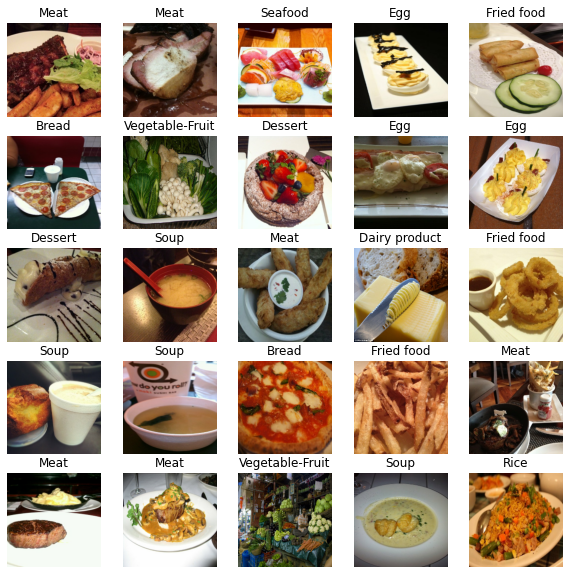

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

## Dataset distribution

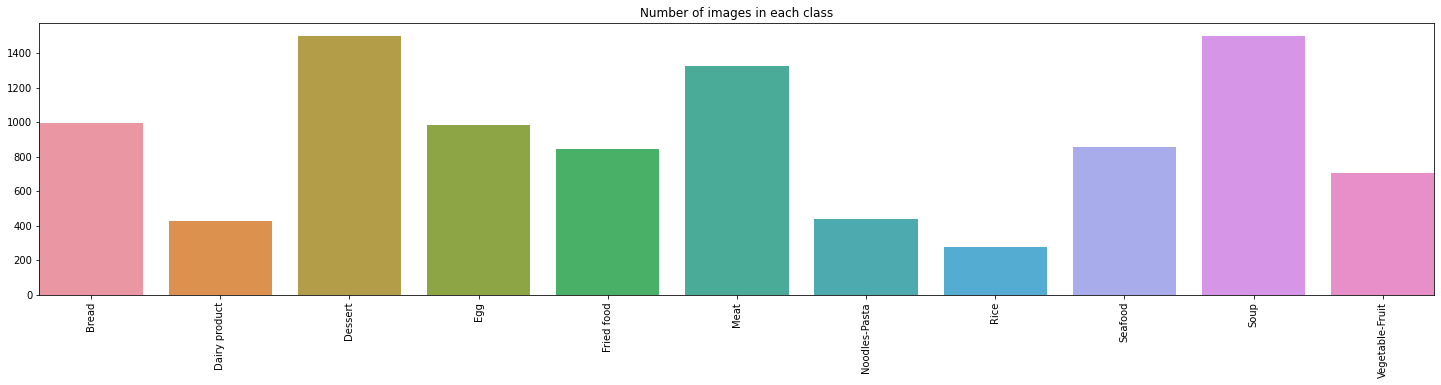

In [ ]:
import seaborn as sns

fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

## Image Augmentation

resize image

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_HEIGHT, IMG_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2)
])

Augmentation Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


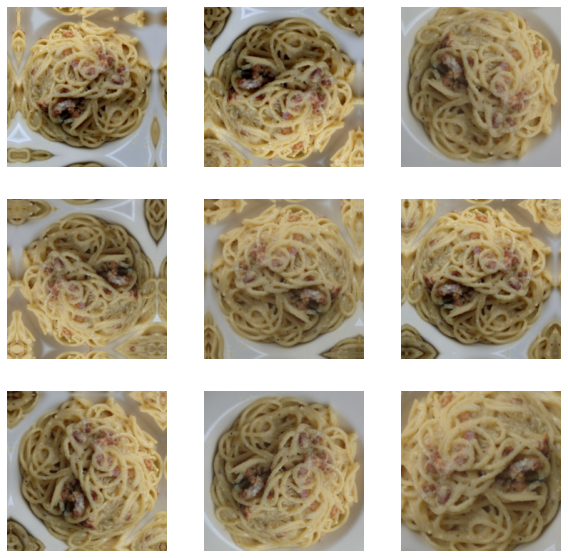

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Build Model

In [ ]:
img_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

model = keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
          resize_and_rescale,
          data_augmentation,
        ])

# Step 1 - Convolution
model.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu'))
model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.BatchNormalization())

# Step 2 - Pooling
model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPool2D())

# Step 3 - Flattening
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))

# Step 4 - Full connection
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 64)       

In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
155/155 [==============================] - 97s 403ms/step - loss: 3.3760 - accuracy: 0.1807 - val_loss: 8.0187 - val_accuracy: 0.2566
Epoch 2/10
155/155 [==============================] - 63s 400ms/step - loss: 1.9406 - accuracy: 0.3103 - val_loss: 5.3432 - val_accuracy: 0.2930
Epoch 3/10
155/155 [==============================] - 64s 405ms/step - loss: 1.8542 - accuracy: 0.3537 - val_loss: 2.0723 - val_accuracy: 0.3638
Epoch 4/10
155/155 [==============================] - 63s 398ms/step - loss: 1.7807 - accuracy: 0.3785 - val_loss: 1.7704 - val_accuracy: 0.3980
Epoch 5/10
155/155 [==============================] - 64s 405ms/step - loss: 1.7268 - accuracy: 0.3929 - val_loss: 1.9329 - val_accuracy: 0.3370
Epoch 6/10
155/155 [==============================] - 64s 403ms/step - loss: 1.6462 - accuracy: 0.4326 - val_loss: 1.7560 - val_accuracy: 0.4012
Epoch 7/10
155/155 [==============================] - 65s 410ms/step - loss: 1.5996 - accuracy: 0.4423 - val_loss: 1.5707 - val_ac

## Evaluating Performance of Model

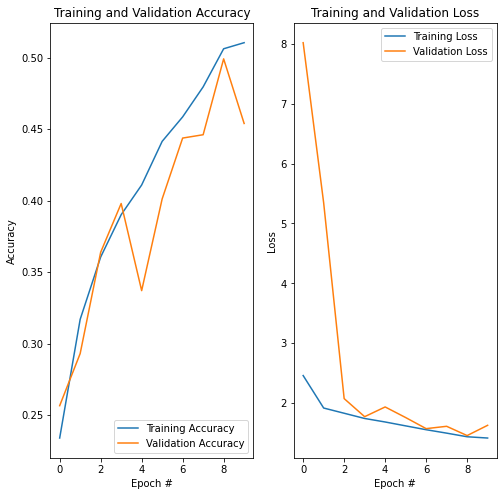

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(
    validation_ds, 
    steps = validation_ds.n // 32, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

Save model

In [ ]:
model.save('trained.h5')

## Prediction

In [ ]:
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [ ]:
prediction = []
original = []
image = []
count = 0
path_eval = PATH + '/evaluation'
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img = PIL.Image.open(os.path.join(path_eval, i, item))
        img = img.resize((224,224))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype=np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,224,224,3)
        #making prediction of the model
        predict = model.predict(img, batch_size=10)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

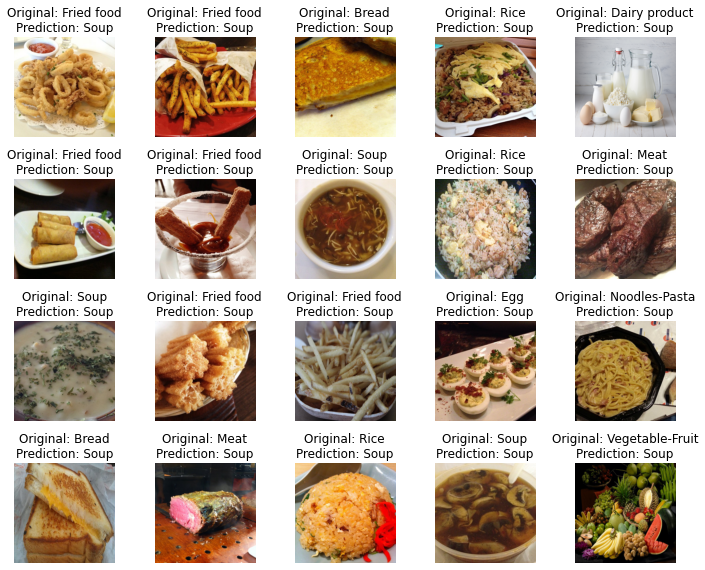

In [ ]:
import random

# Visualizing the results
fig=plt.figure(figsize = (10,10))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(5, 5, i + 1)
    plt.title("Original: " + original[j] + "\nPrediction: " + prediction[j])
    plt.imshow(image[j])
    plt.axis("off")
fig.tight_layout()
plt.show()